In [49]:
import os, sys
from pathlib import Path

BASE_DIR = Path(Path.home(), "workspace", "services", "credit_model")
DATA_DIR = Path(Path.home(), "workspace", "data")
if BASE_DIR not in sys.path:
    sys.path.insert(0, f"{BASE_DIR}")

## 课程大纲

### 课程大纲

In [2]:
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import toad

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from util import woe_helper
from util import woe_mono
from util import report_helper
from util import bm_helper
from util import lgbm_helper
from util import data_helper
from util import score_helper
from util import shap_helper

C:\Users\USER\workspace\services\credit_model


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# 加载数据

In [6]:
fp_data = Path(DATA_DIR, 'tutorial', 'data.csv')
df_data = pd.read_csv(fp_data, index_col=None)

In [7]:
num_cols = ['Collateral_valuation', 'Age', 'Properties_Total', 'Amount', 'Term', 'Historic_Loans', 'Current_Loans', 'Max_Arrears']
cat_cols = ['Region', 'Area', 'Activity', 'Guarantor', 'Collateral', 'Properties_Status']
features = num_cols + cat_cols
label = 'Defaulter'

In [8]:
for c in cat_cols:
    df_data.loc[:, c] = df_data.loc[:, c].apply(lambda x: str(f"cat_{x}"))

# 训练集测试集准备

In [9]:
df_label = data_helper.Data.train_test_split(df_data, 'AppNo', label)
df_sample = df_label[['AppNo', 'sample_type']].merge(df_data, on='AppNo', how='left')
df_train = df_sample[df_sample['sample_type']=='train']
df_test = df_sample[df_sample['sample_type']=='test']

In [10]:
woe = woe_helper.WOE()
woe.fit(df_data, label, exclude=['AppNo', 'sample_type', label], method='dt')
df_woe = woe.transform(df_sample)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 52.98it/s]


finish combiner fit
finish combiner transform


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 59.73it/s]


finish WOE fit


100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 112.06it/s]


# 逻辑回归建模

In [11]:
model = bm_helper.Logit()
model.select_and_fit(
    df_woe.loc[df_woe['sample_type']=='train', features], 
    df_woe.loc[df_woe['sample_type']=='train', label], 
    positive_coef=True)

removed 2 features
{'empty': array([], dtype=float64), 'iv': array(['Current_Loans', 'Guarantor'], dtype=object), 'corr': array([], dtype=object)}


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 199.49it/s]

removed 0 features
[]
Optimization terminated successfully.
         Current function value: 0.379811
         Iterations 7
removed 1 features
['Collateral']
Optimization terminated successfully.
         Current function value: 0.379977
         Iterations 7
['Activity', 'Age', 'Amount', 'Area', 'Collateral_valuation', 'Historic_Loans', 'Max_Arrears', 'Properties_Status', 'Properties_Total', 'Region', 'Term']
removed 0 features
[]
Optimization terminated successfully.
         Current function value: 0.379977
         Iterations 7
removed 1 features
['Collateral_valuation']
Optimization terminated successfully.
         Current function value: 0.379984
         Iterations 7


['Activity', 'Age', 'Amount', 'Area', 'Historic_Loans', 'Max_Arrears', 'Properties_Status', 'Properties_Total', 'Region', 'Term']
Optimization terminated successfully.
         Current function value: 0.379811
         Iterations 7


Logit()

In [12]:
model.get_summary()

,var,coef,std_err,z,pvalue,std_var,feature_importance
const,const,-1.630172,0.02,-106.68,0.00,NaN,NaN
Activity,Activity,0.431017,0.03,15.19,0.00,0.59,0.10
Age,Age,0.797673,0.05,15.93,0.00,0.31,0.10
Amount,Amount,0.588864,0.04,14.20,0.00,0.42,0.10
Area,Area,0.354807,0.04,8.29,0.00,0.39,0.06
Collateral,Collateral,-0.345998,0.09,-3.65,0.00,0.19,0.03
Collateral_valuation,Collateral_valuation,0.126659,0.05,2.44,0.01,0.41,0.02
Historic_Loans,Historic_Loans,0.620143,0.05,13.13,0.00,0.36,0.09
Max_Arrears,Max_Arrears,0.921127,0.06,15.54,0.00,0.23,0.08
Properties_Status,Properties_Status,0.245522,0.06,4.31,0.00,0.25,0.02


In [13]:
df_sample['bm_prob'] = model.predict(df_woe[model.selected_features])

In [14]:
sb = score_helper.Score()
sb.fit(df_sample['bm_prob'], df_sample[label])

In [15]:
df_sample['bm_score'] = sb.transform(df_sample['bm_prob'])

In [16]:
report_helper.ModelReport.get_report(df_sample, 'sample_type', 'bm_score', label)

sample_type,test,train
auc,0.768376,0.770348
ks,0.399438,0.402223
gini,0.536752,0.540696


# LGB建模

In [17]:
gbdt = lgbm_helper.LightGBM()

n_estimators = 500
params = {
    "learning_rate": 0.1,
    "max_depth": 2,
    "num_leaves": 4,
    "min_child_samples": 20,
    "subsample": 1,
    "subsample_freq": 1,
    "colsample_bytree": 1,
    "reg_alpha": 10,
    "reg_lambda": 10,
}
gbdt.fit(df_woe.loc[df_woe['sample_type']=='train', features], 
         df_woe.loc[df_woe['sample_type']=='train', label], 
         df_xvalid=df_woe.loc[df_woe['sample_type']=='test', features],
         df_yvalid=df_woe.loc[df_woe['sample_type']=='test', label],
         n_estimators=n_estimators, params=params)

[2]	valid_0's cross_entropy: 0.672906	valid_1's cross_entropy: 0.672584
[4]	valid_0's cross_entropy: 0.658309	valid_1's cross_entropy: 0.657427
[6]	valid_0's cross_entropy: 0.647096	valid_1's cross_entropy: 0.645749
[8]	valid_0's cross_entropy: 0.637493	valid_1's cross_entropy: 0.636141
[10]	valid_0's cross_entropy: 0.629814	valid_1's cross_entropy: 0.628667
[12]	valid_0's cross_entropy: 0.622749	valid_1's cross_entropy: 0.621447
[14]	valid_0's cross_entropy: 0.617438	valid_1's cross_entropy: 0.616123
[16]	valid_0's cross_entropy: 0.611274	valid_1's cross_entropy: 0.610192
[18]	valid_0's cross_entropy: 0.606669	valid_1's cross_entropy: 0.605638
[20]	valid_0's cross_entropy: 0.602081	valid_1's cross_entropy: 0.601146
[22]	valid_0's cross_entropy: 0.598403	valid_1's cross_entropy: 0.597689
[24]	valid_0's cross_entropy: 0.594707	valid_1's cross_entropy: 0.594394
[26]	valid_0's cross_entropy: 0.591825	valid_1's cross_entropy: 0.591429
[28]	valid_0's cross_entropy: 0.589015	valid_1's cross_

[412]	valid_0's cross_entropy: 0.541541	valid_1's cross_entropy: 0.546992
[414]	valid_0's cross_entropy: 0.541501	valid_1's cross_entropy: 0.546942
[416]	valid_0's cross_entropy: 0.541481	valid_1's cross_entropy: 0.546917
[418]	valid_0's cross_entropy: 0.541481	valid_1's cross_entropy: 0.546937
[420]	valid_0's cross_entropy: 0.541441	valid_1's cross_entropy: 0.546928
[422]	valid_0's cross_entropy: 0.541427	valid_1's cross_entropy: 0.54697
[424]	valid_0's cross_entropy: 0.541369	valid_1's cross_entropy: 0.546919
[426]	valid_0's cross_entropy: 0.541299	valid_1's cross_entropy: 0.546893
[428]	valid_0's cross_entropy: 0.541327	valid_1's cross_entropy: 0.546935
[430]	valid_0's cross_entropy: 0.54129	valid_1's cross_entropy: 0.546903
[432]	valid_0's cross_entropy: 0.541263	valid_1's cross_entropy: 0.546909
[434]	valid_0's cross_entropy: 0.541245	valid_1's cross_entropy: 0.546887
[436]	valid_0's cross_entropy: 0.54123	valid_1's cross_entropy: 0.546885
[438]	valid_0's cross_entropy: 0.54121	va

LightGBM()

In [18]:
gbdt.get_importance()

,feature,split,gain
6,Current_Loans,217,1819.117324
7,Max_Arrears,179,3165.063917
5,Historic_Loans,170,5907.293759
10,Activity,164,7938.904327
8,Region,147,17620.847948
4,Term,112,8897.972510
3,Amount,111,6130.355645
9,Area,99,1616.795208
0,Collateral_valuation,91,504.573135
2,Properties_Total,81,5725.297634


In [19]:
explain = shap_helper.Shap(gbdt, df_woe[gbdt.selected_features], df_woe[label])

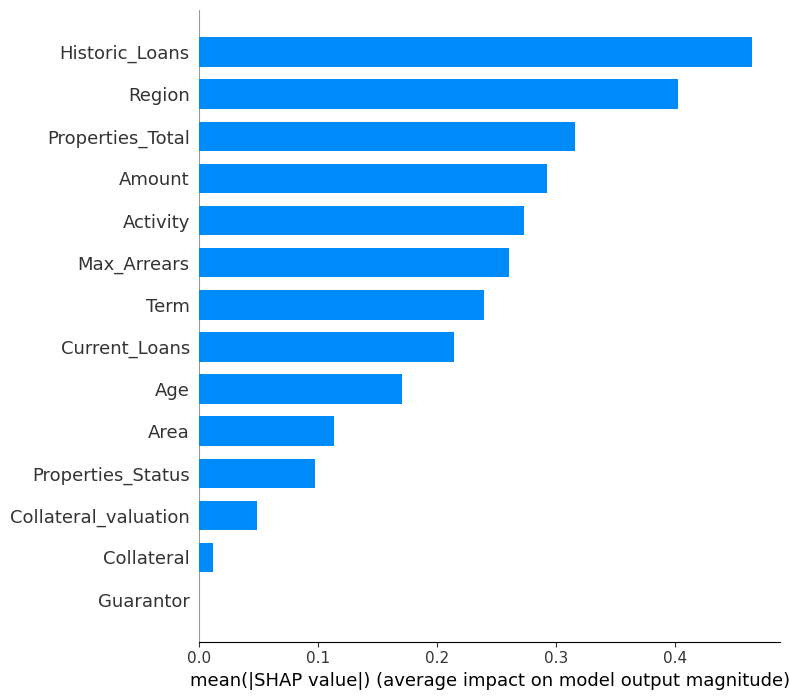

In [20]:
explain.summary_plot()

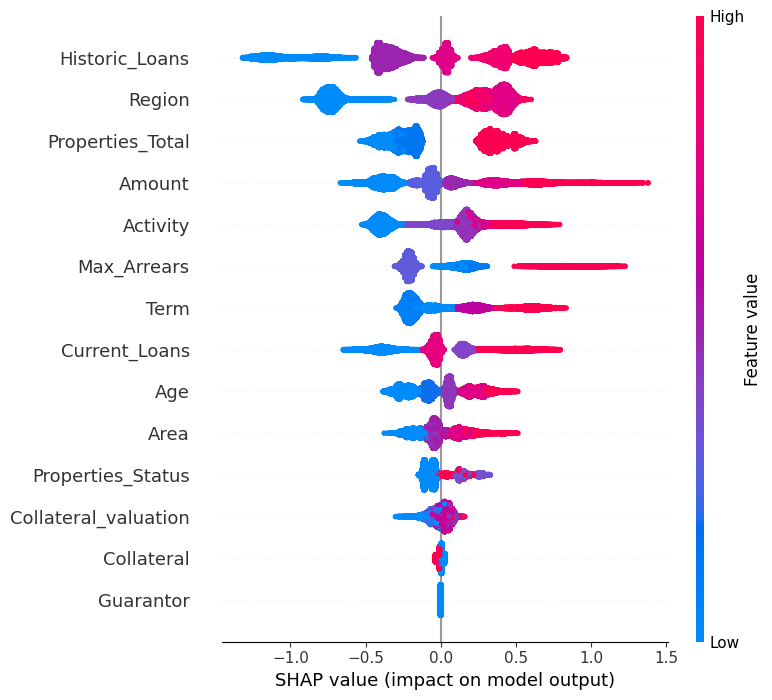

In [21]:
explain.detail_plot()

In [22]:
df_sample['gbdt_prob'] = gbdt.predict(df_woe[gbdt.selected_features])

In [23]:
sb = score_helper.Score()
sb.fit(df_sample['gbdt_prob'], df_sample[label])
df_sample['gbdt_score'] = sb.transform(df_sample['gbdt_prob'])

In [24]:
report_helper.ModelReport.get_report(df_sample, 'sample_type', 'gbdt_score', label)

sample_type,test,train
auc,0.794252,0.804149
ks,0.451860,0.457322
gini,0.588504,0.608298


# LGB模型分析

In [25]:
import lightgbm as lgb

<Axes: >

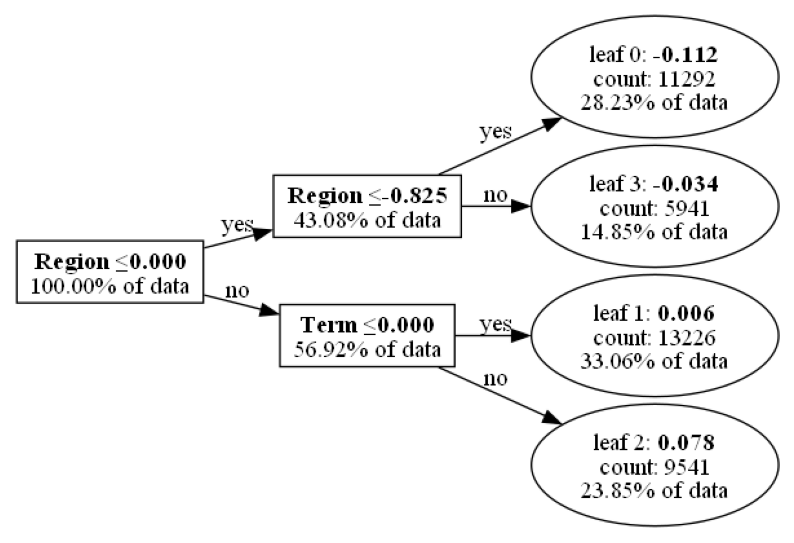

In [26]:
lgb.plot_tree(gbdt.model, tree_index=0, show_info=['leaf_count', 'data_percentage'], figsize=(10, 10))

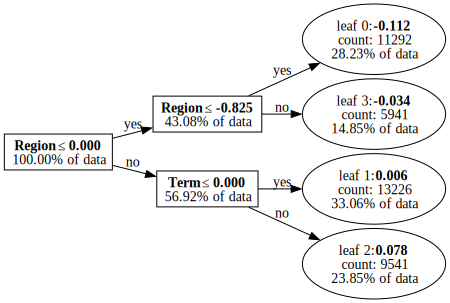

In [27]:
lgb.create_tree_digraph(gbdt.model, tree_index=0, show_info=['leaf_count', 'data_percentage'])

<Axes: title={'center': 'Split value histogram for feature with name Age'}, xlabel='Feature split value', ylabel='Count'>

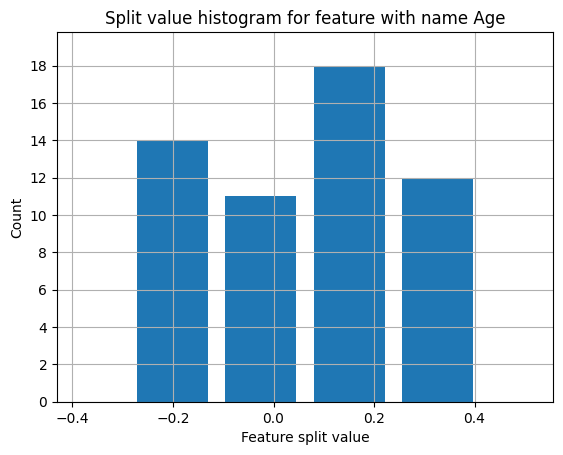

In [28]:
lgb.plot_split_value_histogram(gbdt.model, 'Age')

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='cross_entropy'>

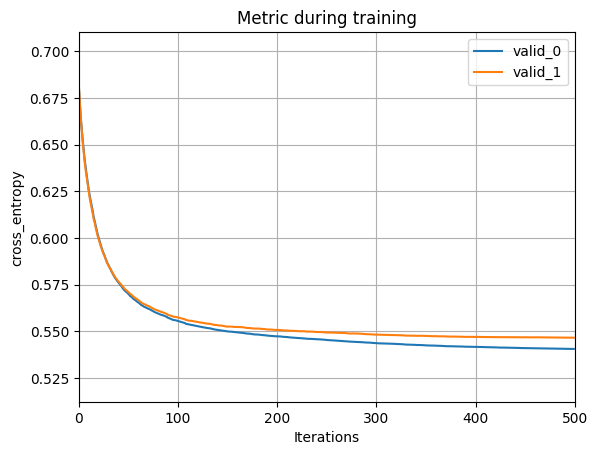

In [29]:
lgb.plot_metric(gbdt.model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

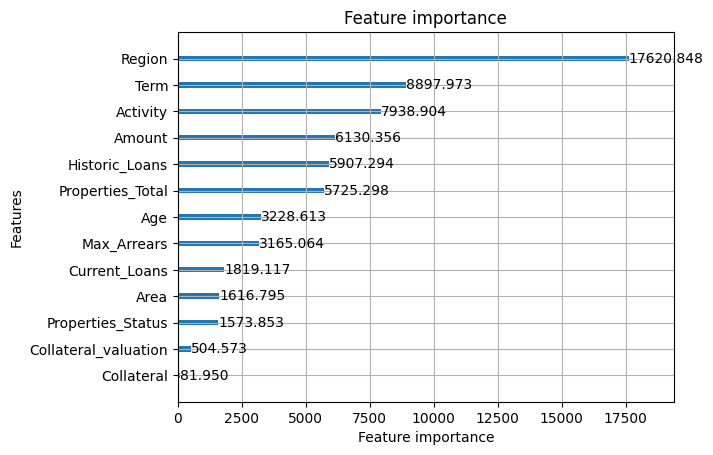

In [30]:
lgb.plot_importance(gbdt.model)

In [31]:
gbdt.get_importance()

,feature,split,gain
6,Current_Loans,217,1819.117324
7,Max_Arrears,179,3165.063917
5,Historic_Loans,170,5907.293759
10,Activity,164,7938.904327
8,Region,147,17620.847948
4,Term,112,8897.972510
3,Amount,111,6130.355645
9,Area,99,1616.795208
0,Collateral_valuation,91,504.573135
2,Properties_Total,81,5725.297634
